# Netflix, Visualization and Machine Learning

## Introduction

In this project, I will analyze a dataset of movies available on the Netflix platform.

The main questions are:

1) Are the movies in the catalogue old or recent?
2) Which is the most popular rating of the catalogue?
3) Is there a relationship between the year of release and the average user rating, starting from 1970?

For the first two questions, we will use the pandas and matplotlib libraries to explore and visualize the dataset.

For the last question, we will use scikit-learn to find a suitable regression model (if one exists) and cross-validate it.

## Libraries, uploading data and explore it

We start the project importing the libraries (Pandas, Matplotlib, NumPy and Scikit-learn), opening the csv file and exploring its features.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor #import libraries
df=pd.read_csv("netflix.csv") 
print(df.info())
print(df.describe()  )
print(df.isna().sum()) #find informations about our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1000 non-null   object 
 1   rating             1000 non-null   object 
 2   ratinglevel        941 non-null    object 
 3   ratingdescription  1000 non-null   int64  
 4   release_year       1000 non-null   int64  
 5   user_rating_score  605 non-null    float64
 6   user_rating_size   1000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB
None
       ratingdescription  release_year  user_rating_score  user_rating_size
count         1000.00000   1000.000000         605.000000       1000.000000
mean            67.36600   2010.335000          84.094215         80.783000
std             30.78561      8.877927          12.344371          0.973066
min             10.00000   1940.000000          55.000000         80.000000
25%            

We notice that "ratinglevel" and "user_rating_score" have 59 and 395 NaN entries. Hence we need to clean the data. 

In order to avoid to lose too much information, we will fill the empty gaps of 'user_rating_score' by doing a mean of the values of the elements of the columns.

In [3]:
df['user_rating_score'] = df['user_rating_score'].fillna(df['user_rating_score'].mean())  #compute the mean to fill 'user_rating_score' column
df_clean = df.dropna(subset=['ratinglevel']) #drop Nan in df['ratinglevel'] and create a new clean dataframe
print(df_clean.isna().sum())
print(df_clean.info()) #check if the dataset is clean

title                0
rating               0
ratinglevel          0
ratingdescription    0
release_year         0
user_rating_score    0
user_rating_size     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 941 entries, 0 to 998
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              941 non-null    object 
 1   rating             941 non-null    object 
 2   ratinglevel        941 non-null    object 
 3   ratingdescription  941 non-null    int64  
 4   release_year       941 non-null    int64  
 5   user_rating_score  941 non-null    float64
 6   user_rating_size   941 non-null    int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 58.8+ KB
None


After cleaning, the dataset has **941 entries** (down from 1000), which may affect modeling.

## Visualization

Now we want to understand if the movies on the catalogue are recent or  old.

To do it we use the groupby method for Dataframe in Pandas, then we count the number of movies per year and we plot them on a graph.

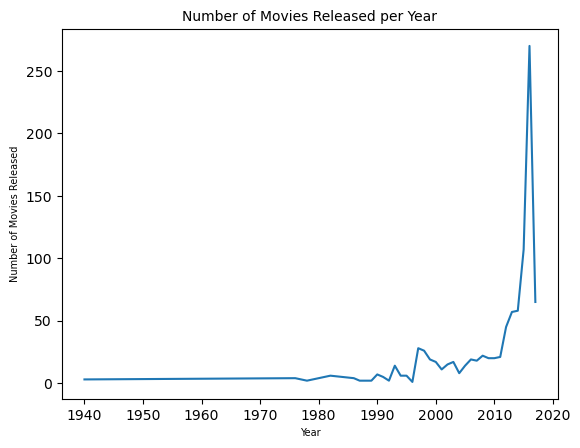

In [4]:
movie_per_year = df_clean.groupby('release_year').size().sort_index()  #visualize number of movies released per year
plt.plot(movie_per_year.index, movie_per_year.values) #plot
plt.xlabel('Year', fontsize=7)
plt.ylabel('Number of Movies Released', fontsize=7)
plt.title('Number of Movies Released per Year', fontsize=10)
plt.show() #plot the graph

We notice that the number of recent movies is far superior to that of older ones.  

Next, we will plot the distribution of Netflix ratings using a bar chart.

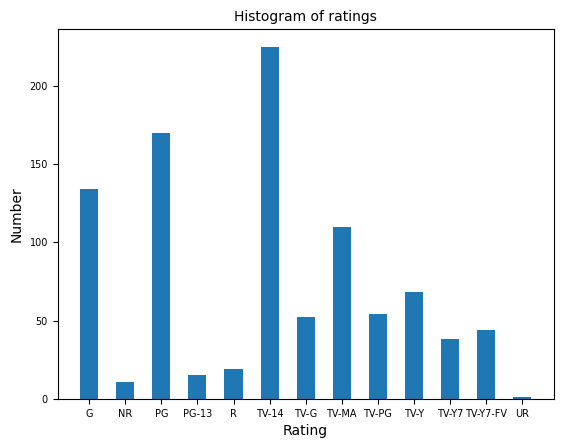

In [5]:
rd = df_clean.groupby('rating').size().sort_index() 
plt.bar(rd.index, rd.values, width=0.5)
plt.xticks(rd.index, fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Rating')
plt.ylabel('Number')
plt.title('Histogram of ratings', fontsize=10)
plt.show()

Now we want to visualize the relation between years and rating scores of the users. 

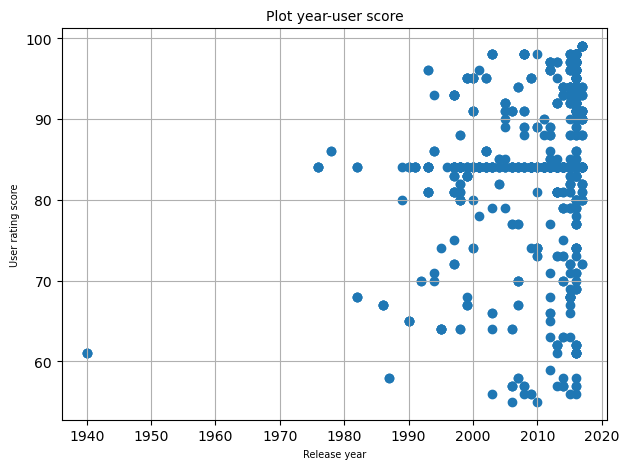

In [6]:
plt.scatter(df_clean['release_year'], df_clean['user_rating_score'], marker='o')            
plt.xlabel('Release year', fontsize=7)
plt.ylabel('User rating score', fontsize=7)
plt.title('Plot year-user scores', fontsize=10)
plt.grid(True)                       
plt.tight_layout()
plt.show()

We notice that most movies were released after 1978.  

We now compute the mean score per year and exclude the single 1940 entry to focus on post-1970 movies.

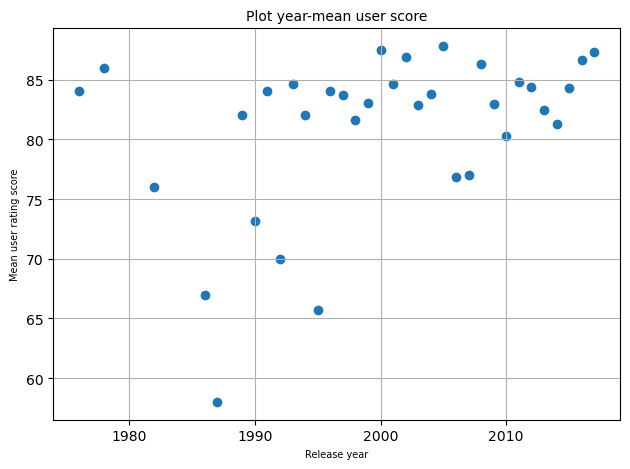

In [7]:
mean_per_year = df_clean.groupby('release_year')['user_rating_score'].mean().sort_index() #we compute the mean for every year
mean_per_year = mean_per_year.drop(1940) #we exclude the year before 1970
plt.scatter(mean_per_year.index, mean_per_year.values, marker='o') 
plt.xlabel('Release year', fontsize=7)
plt.ylabel('Mean user rating score', fontsize=7)
plt.title('Plot year-mean user scores', fontsize=10)
plt.grid(True)                       
plt.tight_layout() #plot the graph
plt.show()
year=np.array(list(mean_per_year.index)).reshape(-1,1) #prepare arrays for regressions
rates=np.array(list(mean_per_year.values))

## Regression

In this section we will try to find a model to see if there is a relationship between years and avarage user scores.

We start our investigation on the model by doing a standard linear regression.

We compute also the MSE and R^2 test on train and validation sets to check if the regression works correctly

In [8]:
X_train, X_test, y_train, y_test = train_test_split(year, rates, test_size=0.2, random_state=5) #split 80/20
lr = LinearRegression()
lr.fit(X_train, y_train) #linear regression
y_train_pred = lr.predict(X_train)
y_test_pred  = lr.predict(X_test) 
mse_train = mean_squared_error(y_train, y_train_pred) #check model computing MSE and R^2 test
r2_train  = r2_score(y_train, y_train_pred) 
mse_test  = mean_squared_error(y_test, y_test_pred)
r2_test   = r2_score(y_test, y_test_pred)
print("TRAINING   → MSE: {:.4f}, R²: {:.4f}".format(mse_train, r2_train))
print("TEST (20%) → MSE: {:.4f}, R²: {:.4f}".format(mse_test,  r2_test))

TRAINING   → MSE: 39.0322, R²: 0.1742
TEST (20%) → MSE: 42.9562, R²: -0.0337


The results show low R² and high MSE, suggesting little to no linear trend between year and rating in this dataset.

We try now a polynomial regression in order to understand if there is a better fit.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(year, rates, test_size=0.2, random_state=5) #split 80/20
poly = PolynomialFeatures(degree=2, include_bias=False) #polynomial regression of degree 2
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)
model = LinearRegression()
model.fit(X_train_poly, y_train)
y_train_pred = model.predict(X_train_poly)
y_test_pred  = model.predict(X_test_poly)
mse_train = mean_squared_error(y_train, y_train_pred) #check model computing MSE and R^2 test
r2_train  = r2_score(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)
r2_test   = r2_score(y_test, y_test_pred)
print("POLY DEGREE=2 TRAIN → MSE: {:.4f}, R²: {:.4f}".format(mse_train, r2_train))
print("POLY DEGREE=2 TEST  → MSE: {:.4f}, R²: {:.4f}".format(mse_test,  r2_test))

POLY DEGREE=2 TRAIN → MSE: 38.3727, R²: 0.1881
POLY DEGREE=2 TEST  → MSE: 40.1475, R²: 0.0339


The fit on training data improves slightly but it is still poor, with R^2 near zero. 

We notice from the graph and from the scatter plot that the structure of the data is highly nonlinear.

Hence we change now strategy, using a KNN algorithm with k=6.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(year, rates, test_size=0.2, random_state=5) #split 80/20
knn = KNeighborsRegressor(n_neighbors=6, weights='distance') #KNN Regression
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)
y_test_pred  = knn.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred) #check model computing MSE and R^2 test
r2_train  = r2_score(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)
r2_test   = r2_score(y_test, y_test_pred)
print("KNN TRAIN → MSE: {:.4f}, R²: {:.4f}".format(mse_train, r2_train))
print("KNN TRAIN  → MSE: {:.4f}, R²: {:.4f}".format(mse_test,  r2_test))

KNN TRAIN → MSE: 0.0000, R²: 1.0000
KNN TRAIN  → MSE: 24.5985, R²: 0.4081


KNN has a better R² with the test data, but the value is not impressive. 

Hence we try the Random Forest Regression to check if we may improve the result.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(year, rates, test_size=0.2, random_state=5) #split 80/20
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=5) #Random Forest Regressor
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)
y_test_pred  = rf.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred) #check model computing MSE and R^2 test
r2_train  = r2_score(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)
r2_test   = r2_score(y_test, y_test_pred)
print("RN TRAIN → MSE: {:.4f}, R²: {:.4f}".format(mse_train, r2_train))
print("RN TEST  → MSE: {:.4f}, R²: {:.4f}".format(mse_test,  r2_test))

RN TRAIN → MSE: 7.7374, R²: 0.8363
RN TEST  → MSE: 31.6080, R²: 0.2394


Random Forest performs worse than the KNN algorithm.

Now we may cross-validate these models to have a more solid evaluation.


In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=5)
scores = cross_val_score(knn, year, rates, cv=cv) #cross-validation KNN
print("Mean R² KNN:", scores.mean())


cv = KFold(n_splits=5, shuffle=True, random_state=5)
scores = cross_val_score(rf, year, rates, cv=cv) #cross-validation Random Forest
print("Mean R² Random Forest:", scores.mean())

Mean R² KNN: -0.184899343299395
Mean R² Random Forest: -1.238410314465666


We notice that the cross-validations have a mean R² that is less than zero, indicating that these models are not performing well for regression.

## Conclusions

- The Netflix catalog contains more recent movies than older ones.
- The most popular rating is TV-14.
- User ratings for Netflix movies do not show a strong trend over time in this dataset.
- In a real-world scenario, including more features (genre, cast, director, etc.) may improve model performance.